In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import keras
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint

import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix   

2023-05-26 04:31:35.528157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-26 04:31:35.528196: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Import the data

In [2]:
import pandas as pd
from sklearn.utils import shuffle

# Read the CSV file into a pandas DataFrame
data = pd.read_csv("rumus + data skripsi angka polos jarak dan visibilitas 2.csv")

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

def get_data_with_ratio(ratio):
    # Membaca data dari file CSV menggunakan Pandas
    data = pd.read_csv("rumus + data skripsi angka polos jarak dan visibilitas 2.csv")
    data = data[["Peruntukan","Jarak_pusat_kota2","Visibilitas","Bangunan","Luas"]]

    # Memisahkan data berdasarkan kolom "Peruntukan"
    peruntukan_data = {}
    for label in ['Sawah', 'Perumahan', 'Taman', 'Ruko', 'Kantor', 'Pasar']:
        peruntukan_data[label] = data[data['Peruntukan'] == label]

    # Memeriksa setiap label untuk memastikan ada minimal satu data
    for label in peruntukan_data:
        if peruntukan_data[label].empty:
            print(f"Label {label} tidak memiliki data yang mewakili")
            return None

    # Menginisialisasi data pelatihan dan pengujian
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    # Memisahkan data pelatihan dan pengujian berdasarkan rasio
    for label in peruntukan_data:
        label_train, label_test = train_test_split(peruntukan_data[label], test_size=ratio, random_state=42, shuffle = False)
        train_data = train_data.append(label_train)
        test_data = test_data.append(label_test)

    # Mengembalikan data pelatihan dan pengujian
    print(train_data)
    print(test_data)
    return train_data, test_data


# Data visualisasi

# Change categorical to number 

In [4]:
def change_categorical_to_number(data):

    
 
    ####
    ####

    condition = [  data.Visibilitas == "Strategis",
                 data.Visibilitas == "Sedang",
                  data.Visibilitas == "Kurang",
    ]

    value = [3,2,1]

    data.Visibilitas = np.select(condition,value)
    #####
    #####

    condition = [  data.Bangunan == "Bagus",
                 data.Bangunan == "Sedang",

    ]

    value = [2,1]

    data.Bangunan = np.select(condition,value,0)


    condition = [ 
                data.Peruntukan == "Pasar",
                 data.Peruntukan == "Kantor",
                 data.Peruntukan == "Ruko",
                 data.Peruntukan == "Taman",
                 data.Peruntukan == "Perumahan",
                 data.Peruntukan == "Sawah",

    ]

    value = [5,4,3,2,1,0]

    data.Peruntukan = np.select(condition,value,0)
    
    return data

# Dataframe to Dataset

In [5]:
def df_to_dataset(dataframe, shuffle=False, batch_size=2):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Peruntukan')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  #if shuffle:
  #  ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

# Feature Normalizer

In [6]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [7]:
def encoded_features(train_ds):
    all_inputs = []
    encoded_features = []

    # Numerical features.
    for header in ["Jarak_pusat_kota2","Visibilitas","Bangunan","Luas"]:
      numeric_col = tf.keras.Input(shape=(1,), name=header)
      normalization_layer = get_normalization_layer(header, train_ds)
      encoded_numeric_col = normalization_layer(numeric_col)
      all_inputs.append(numeric_col)
      encoded_features.append(encoded_numeric_col)
    return encoded_features, all_inputs

In [8]:
checkpoint_callback = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')

# Model build

In [9]:
def model(encoded_features,all_inputs):
    
    all_features = tf.keras.layers.concatenate(encoded_features)
    x = tf.keras.layers.Dense(32, activation="relu")(all_features)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(6)(x)

    model = tf.keras.Model(all_inputs, output)

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics="accuracy",
                 )
    
    return model

# History build

In [10]:
def history(model,callbacks,train_ds,val_ds):
    

    history = model.fit(train_ds, epochs=150, validation_data=val_ds, callbacks=callbacks)

    # Get the training and validation metrics from the history
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot accuracy
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    max_test_accuracy_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))

    # Get the corresponding training accuracy
    training_accuracy = history.history['accuracy'][max_test_accuracy_index]

    print('Best validation accuracy:', max(history.history['val_accuracy']))
    print('Training accuracy at the best test accuracy:', training_accuracy)
    
    return history


# Evaluation the Model

In [11]:
def run_model(ratio,callbacks):
    
    #split data
    training, test_2 = get_data_with_ratio(ratio)
    
    #change data to number
    training = change_categorical_to_number(training)
    test = change_categorical_to_number(test_2)
    
    #df to ds
    
    train_ds = df_to_dataset(training)
    val_ds = df_to_dataset(test)
    
    #encoded features
    
    encoded,inputs = encoded_features(train_ds)

    
    #set the model
    model_engine = model(encoded,inputs)
    
    #run and evaluate the model
    model_engine2 = history(model_engine,callbacks,train_ds,val_ds)
    
    #evaluate confusion matrix
    confussion_matrix(model_engine2,val_ds,test_2)

In [12]:
def confussion_matrix(best_model, val_ds, test_data):
    from sklearn.metrics import confusion_matrix   
    model = best_model
    
    y_pred = model.model.predict(val_ds)

    # Ubah output prediksi menjadi label kelas
    label_kelas = [0, 1, 2, 3, 4, 5]
    y_pred_label = [label_kelas[np.argmax(prediksi)] for prediksi in y_pred]

    # Test labels
    test_labels = test_data.Peruntukan

    # Calculate the confusion matrix
    cm = confusion_matrix(test_labels, y_pred_label)
    
    val_accuracy = model.history['val_accuracy']
    train_accuracy = model.history['accuracy']

    # Find the index where validation accuracy is highest
    max_val_accuracy_index = np.argmax(val_accuracy)

    # Find the index of the closest training accuracy to the maximum validation accuracy
    closest_train_accuracy_index = np.argmin([abs(i - max_val_accuracy_index) for i in range(len(train_accuracy))])

    print('Best validation accuracy:', val_accuracy[max_val_accuracy_index])
    print('Closest training accuracy to the maximum validation accuracy:', train_accuracy[closest_train_accuracy_index])




    print('Confusion matrix:')
    print(cm)
    
    confusion_matrix = cm
    
    true_positives = np.diagonal(confusion_matrix)

    # Step 3: Calculate the accuracy percentage for each class
    class_data_totals = np.sum(confusion_matrix, axis=0)
    class_accuracies = true_positives / class_data_totals * 100

    # Step 4: Calculate the overall accuracy percentage
    total_instances = np.sum(confusion_matrix)
    overall_accuracy = np.sum(true_positives) / total_instances * 100

    
 
    
    
    
    true_positives = np.diagonal(confusion_matrix)
    false_positives = np.sum(confusion_matrix, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix, axis=1) - true_positives

    # Step 3: Calculate precision, recall, and F1 score for each label
    accuracy = true_positives / np.sum(confusion_matrix, axis=1)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Step 4: Calculate the total accuracy
    total_accuracy = np.sum(true_positives) / np.sum(confusion_matrix) * 100
    total_precision = np.mean(precision)
    total_recall = np.mean(recall)
    total_f1 = np.mean(f1_score)

    # Print the results
    print("Total Accuracy:", total_accuracy)
    print("Total Precision:", total_precision)
    print("Total Recall:", total_recall)
    
    print("TP for each label", true_positives)
    print("Total data for each label",  np.sum(confusion_matrix, axis=1))
    print("FP for each label", np.sum(confusion_matrix, axis=0) - true_positives)
    print("FN for each label", np.sum(confusion_matrix, axis=1) - true_positives)
    # Print the results
    print("Accuracy for each label:", class_accuracies)
    print("Precision for each label:", precision)
    print("Recall for each label:", recall)

    

# Model Evaluation

In [13]:
callback_1 = ModelCheckpoint("50.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_1 = 0.5

callback_2= ModelCheckpoint("40.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_2 = 0.4

callback_3= ModelCheckpoint("30.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_3 = 0.3

callback_4= ModelCheckpoint("20.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_4 = 0.2

callback_5= ModelCheckpoint("10.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_5 = 0.1

/tmp/ipykernel_191015/820102873.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(label_train)
/tmp/ipykernel_191015/820102873.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(label_test)
/tmp/ipykernel_191015/820102873.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(label_train)
/tmp/ipykernel_191015/820102873.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(label_test)
/tmp/ipykernel_191015/820102873.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futur

   Peruntukan  Jarak_pusat_kota2 Visibilitas Bangunan   Luas
4       Sawah        5078.908690      Kurang   Kosong  45000
6       Sawah        1879.054170      Kurang   Kosong  18340
7       Sawah        1998.062583      Kurang   Kosong  18110
8       Sawah        2040.538807      Kurang   Kosong  17770
14      Sawah        1629.234516      Kurang   Kosong  13155
15      Sawah        4169.365079      Kurang   Kosong  10390
19      Sawah        2180.832903      Kurang   Kosong   7745
21      Sawah        3982.014575      Kurang   Kosong   6650
22      Sawah        2766.267155      Kurang   Kosong   6635
23      Sawah        4216.298352      Kurang   Kosong   6390
24      Sawah        2194.611053      Kurang   Kosong   6271
1   Perumahan        2289.806804      Sedang   Sedang  87580
2   Perumahan        4495.038477      Kurang   Sedang  57945
5   Perumahan        2535.506573      Sedang   Sedang  27024
9       Taman        1311.091484   Strategis   Kosong  17033
59      Taman          3

25/25 [==============================] - 0s 4ms/step - loss: 1.1863 - accuracy: 0.6531 - val_loss: 1.7430 - val_accuracy: 0.5556
Epoch 14/150
25/25 [==============================] - 0s 4ms/step - loss: 1.0869 - accuracy: 0.7143 - val_loss: 1.7558 - val_accuracy: 0.5556
Epoch 15/150
25/25 [==============================] - 0s 5ms/step - loss: 1.1090 - accuracy: 0.7143 - val_loss: 1.7517 - val_accuracy: 0.5741
Epoch 16/150
25/25 [==============================] - 0s 4ms/step - loss: 1.1242 - accuracy: 0.7143 - val_loss: 1.7157 - val_accuracy: 0.5741
Epoch 17/150
25/25 [==============================] - 0s 5ms/step - loss: 1.1414 - accuracy: 0.6327 - val_loss: 1.7449 - val_accuracy: 0.5926
Epoch 18/150
25/25 [==============================] - 0s 4ms/step - loss: 1.0495 - accuracy: 0.6122 - val_loss: 1.7341 - val_accuracy: 0.5926
Epoch 19/150
25/25 [==============================] - 0s 4ms/step - loss: 1.1219 - accuracy: 0.6939 - val_loss: 1.7140 - val_accuracy: 0.5926
Epoch 20/150
25/25 

Epoch 71/150
25/25 [==============================] - 0s 4ms/step - loss: 0.4910 - accuracy: 0.8163 - val_loss: 2.1563 - val_accuracy: 0.7037
Epoch 72/150
25/25 [==============================] - 0s 4ms/step - loss: 0.3857 - accuracy: 0.8571 - val_loss: 2.1746 - val_accuracy: 0.7037
Epoch 73/150
25/25 [==============================] - 0s 4ms/step - loss: 0.4918 - accuracy: 0.8163 - val_loss: 2.2017 - val_accuracy: 0.7037
Epoch 74/150
25/25 [==============================] - 0s 4ms/step - loss: 0.4391 - accuracy: 0.9184 - val_loss: 2.1715 - val_accuracy: 0.7037
Epoch 75/150
25/25 [==============================] - 0s 4ms/step - loss: 0.5294 - accuracy: 0.8980 - val_loss: 2.1926 - val_accuracy: 0.7037
Epoch 76/150
25/25 [==============================] - 0s 4ms/step - loss: 0.4757 - accuracy: 0.8367 - val_loss: 2.2086 - val_accuracy: 0.7037
Epoch 77/150
25/25 [==============================] - 0s 4ms/step - loss: 0.4534 - accuracy: 0.8571 - val_loss: 2.2811 - val_accuracy: 0.7037
Epoch 

25/25 [==============================] - 0s 4ms/step - loss: 0.3200 - accuracy: 0.8571 - val_loss: 3.2535 - val_accuracy: 0.7037
Epoch 129/150
25/25 [==============================] - 0s 4ms/step - loss: 0.2856 - accuracy: 0.9388 - val_loss: 3.3752 - val_accuracy: 0.7037
Epoch 130/150
25/25 [==============================] - 0s 4ms/step - loss: 0.4289 - accuracy: 0.7959 - val_loss: 3.4214 - val_accuracy: 0.7037
Epoch 131/150
25/25 [==============================] - 0s 4ms/step - loss: 0.3199 - accuracy: 0.8571 - val_loss: 3.4203 - val_accuracy: 0.7037
Epoch 132/150
25/25 [==============================] - 0s 5ms/step - loss: 0.3406 - accuracy: 0.8367 - val_loss: 3.3654 - val_accuracy: 0.7037
Epoch 133/150
25/25 [==============================] - 0s 5ms/step - loss: 0.3032 - accuracy: 0.8980 - val_loss: 3.3594 - val_accuracy: 0.7037
Epoch 134/150
25/25 [==============================] - 0s 4ms/step - loss: 0.3830 - accuracy: 0.8776 - val_loss: 3.4325 - val_accuracy: 0.7037
Epoch 135/150

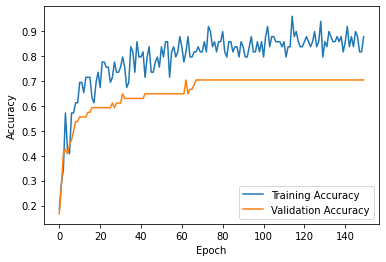

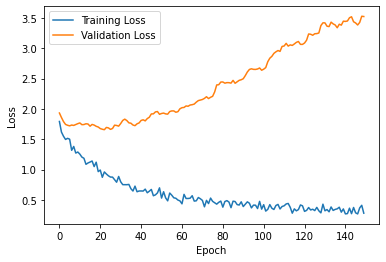

Best validation accuracy: 0.7037037014961243
Training accuracy at the best test accuracy: 0.8163265585899353
Best validation accuracy: 0.7037037014961243
Closest training accuracy to the maximum validation accuracy: 0.8163265585899353
Confusion matrix:
[[12  0  0  0  0  0]
 [ 2  0  0  2  0  0]
 [ 0  0  3  0  0  0]
 [ 3  0  0 15  0  0]
 [ 0  0  0  0  4  3]
 [ 0  0  0  0  6  4]]
Total Accuracy: 70.37037037037037
Total Precision: nan
Total Recall: 0.6341269841269842
TP for each label [12  0  3 15  4  4]
Total data for each label [12  4  3 18  7 10]
FP for each label [5 0 0 2 6 3]
FN for each label [0 4 0 3 3 6]
Accuracy for each label: [ 70.58823529          nan 100.          88.23529412  40.
  57.14285714]
Precision for each label: [0.70588235        nan 1.         0.88235294 0.4        0.57142857]
Recall for each label: [1.         0.         1.         0.83333333 0.57142857 0.4       ]


/tmp/ipykernel_191015/2608161719.py:41: RuntimeWarning: invalid value encountered in divide
  class_accuracies = true_positives / class_data_totals * 100
/tmp/ipykernel_191015/2608161719.py:58: RuntimeWarning: invalid value encountered in divide
  precision = true_positives / (true_positives + false_positives)


In [14]:
run_model(ratio_1, callback_1)

/tmp/ipykernel_191015/820102873.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(label_train)
/tmp/ipykernel_191015/820102873.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(label_test)
/tmp/ipykernel_191015/820102873.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(label_train)
/tmp/ipykernel_191015/820102873.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(label_test)
/tmp/ipykernel_191015/820102873.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futur

   Peruntukan  Jarak_pusat_kota2 Visibilitas Bangunan   Luas
4       Sawah        5078.908690      Kurang   Kosong  45000
6       Sawah        1879.054170      Kurang   Kosong  18340
7       Sawah        1998.062583      Kurang   Kosong  18110
8       Sawah        2040.538807      Kurang   Kosong  17770
14      Sawah        1629.234516      Kurang   Kosong  13155
15      Sawah        4169.365079      Kurang   Kosong  10390
19      Sawah        2180.832903      Kurang   Kosong   7745
21      Sawah        3982.014575      Kurang   Kosong   6650
22      Sawah        2766.267155      Kurang   Kosong   6635
23      Sawah        4216.298352      Kurang   Kosong   6390
24      Sawah        2194.611053      Kurang   Kosong   6271
25      Sawah        2769.702392      Kurang   Kosong   6065
30      Sawah        1886.691962      Kurang   Kosong   5720
1   Perumahan        2289.806804      Sedang   Sedang  87580
2   Perumahan        4495.038477      Kurang   Sedang  57945
5   Perumahan        253

30/30 [==============================] - 0s 4ms/step - loss: 1.1472 - accuracy: 0.6667 - val_loss: 2.9022 - val_accuracy: 0.6279
Epoch 14/150
30/30 [==============================] - 0s 4ms/step - loss: 1.1243 - accuracy: 0.6667 - val_loss: 2.8472 - val_accuracy: 0.6279
Epoch 15/150
30/30 [==============================] - 0s 5ms/step - loss: 1.2141 - accuracy: 0.5500 - val_loss: 2.8361 - val_accuracy: 0.6512
Epoch 16/150
30/30 [==============================] - 0s 5ms/step - loss: 1.1484 - accuracy: 0.6833 - val_loss: 2.8231 - val_accuracy: 0.6744
Epoch 17/150
30/30 [==============================] - 0s 4ms/step - loss: 1.1208 - accuracy: 0.6833 - val_loss: 2.7730 - val_accuracy: 0.6279
Epoch 18/150
30/30 [==============================] - 0s 4ms/step - loss: 1.0363 - accuracy: 0.6333 - val_loss: 2.7394 - val_accuracy: 0.6512
Epoch 19/150
30/30 [==============================] - 0s 4ms/step - loss: 0.9754 - accuracy: 0.7333 - val_loss: 2.6995 - val_accuracy: 0.6279
Epoch 20/150
30/30 

Epoch 71/150
30/30 [==============================] - 0s 4ms/step - loss: 0.4491 - accuracy: 0.8167 - val_loss: 3.2829 - val_accuracy: 0.6512
Epoch 72/150
30/30 [==============================] - 0s 4ms/step - loss: 0.4937 - accuracy: 0.8333 - val_loss: 3.3138 - val_accuracy: 0.6512
Epoch 73/150
30/30 [==============================] - 0s 4ms/step - loss: 0.5222 - accuracy: 0.8167 - val_loss: 3.3136 - val_accuracy: 0.6512
Epoch 74/150
30/30 [==============================] - 0s 4ms/step - loss: 0.5005 - accuracy: 0.8500 - val_loss: 3.3396 - val_accuracy: 0.6512
Epoch 75/150
30/30 [==============================] - 0s 4ms/step - loss: 0.5265 - accuracy: 0.7667 - val_loss: 3.3628 - val_accuracy: 0.6512
Epoch 76/150
30/30 [==============================] - 0s 4ms/step - loss: 0.5077 - accuracy: 0.8333 - val_loss: 3.3608 - val_accuracy: 0.6512
Epoch 77/150
30/30 [==============================] - 0s 4ms/step - loss: 0.5304 - accuracy: 0.8167 - val_loss: 3.3715 - val_accuracy: 0.6512
Epoch 

30/30 [==============================] - 0s 4ms/step - loss: 0.3589 - accuracy: 0.9000 - val_loss: 4.5292 - val_accuracy: 0.6744
Epoch 129/150
30/30 [==============================] - 0s 4ms/step - loss: 0.3778 - accuracy: 0.7833 - val_loss: 4.5077 - val_accuracy: 0.6744
Epoch 130/150
30/30 [==============================] - 0s 4ms/step - loss: 0.3745 - accuracy: 0.8667 - val_loss: 4.5461 - val_accuracy: 0.6744
Epoch 131/150
30/30 [==============================] - 0s 4ms/step - loss: 0.3128 - accuracy: 0.9000 - val_loss: 4.5992 - val_accuracy: 0.6744
Epoch 132/150
30/30 [==============================] - 0s 5ms/step - loss: 0.4335 - accuracy: 0.8333 - val_loss: 4.6516 - val_accuracy: 0.6744
Epoch 133/150
30/30 [==============================] - 0s 5ms/step - loss: 0.3415 - accuracy: 0.8667 - val_loss: 4.5641 - val_accuracy: 0.6744
Epoch 134/150
30/30 [==============================] - 0s 4ms/step - loss: 0.3152 - accuracy: 0.9167 - val_loss: 4.5880 - val_accuracy: 0.6744
Epoch 135/150

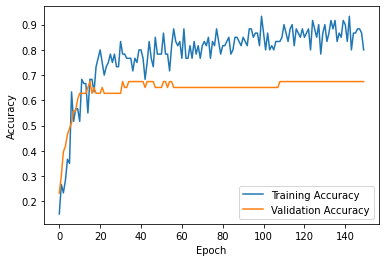

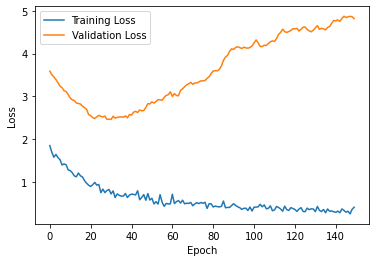

Best validation accuracy: 0.6744186282157898
Training accuracy at the best test accuracy: 0.6833333373069763
Best validation accuracy: 0.6744186282157898
Closest training accuracy to the maximum validation accuracy: 0.6833333373069763
Confusion matrix:
[[ 9  1  0  0  0  0]
 [ 3  0  0  0  0  0]
 [ 0  0  2  0  0  0]
 [ 0  3  0 11  0  0]
 [ 0  0  0  0  6  0]
 [ 0  0  0  0  7  1]]
Total Accuracy: 67.44186046511628
Total Precision: 0.701923076923077
Total Recall: 0.6351190476190476
TP for each label [ 9  0  2 11  6  1]
Total data for each label [10  3  2 14  6  8]
FP for each label [3 4 0 0 7 0]
FN for each label [1 3 0 3 0 7]
Accuracy for each label: [ 75.           0.         100.         100.          46.15384615
 100.        ]
Precision for each label: [0.75       0.         1.         1.         0.46153846 1.        ]
Recall for each label: [0.9        0.         1.         0.78571429 1.         0.125     ]


/tmp/ipykernel_191015/2608161719.py:60: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * (precision * recall) / (precision + recall)


In [15]:
run_model(ratio_2, callback_2)

/tmp/ipykernel_191015/820102873.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(label_train)
/tmp/ipykernel_191015/820102873.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(label_test)
/tmp/ipykernel_191015/820102873.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(label_train)
/tmp/ipykernel_191015/820102873.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(label_test)
/tmp/ipykernel_191015/820102873.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futur

   Peruntukan  Jarak_pusat_kota2 Visibilitas Bangunan   Luas
4       Sawah        5078.908690      Kurang   Kosong  45000
6       Sawah        1879.054170      Kurang   Kosong  18340
7       Sawah        1998.062583      Kurang   Kosong  18110
8       Sawah        2040.538807      Kurang   Kosong  17770
14      Sawah        1629.234516      Kurang   Kosong  13155
..        ...                ...         ...      ...    ...
27      Pasar        1630.361226   Strategis    Bagus   5872
28      Pasar         251.818587   Strategis    Bagus   5785
29      Pasar        1730.459693   Strategis    Bagus   5784
32      Pasar        2406.214384   Strategis    Bagus   5200
57      Pasar        1031.829535   Strategis    Bagus   2252

[69 rows x 5 columns]
    Peruntukan  Jarak_pusat_kota2 Visibilitas Bangunan  Luas
42       Sawah        4969.756040      Kurang   Kosong  3865
49       Sawah        2875.327282      Kurang   Kosong  3220
50       Sawah        2614.434517      Kurang   Kosong  3176
5

35/35 [==============================] - 0s 4ms/step - loss: 0.6631 - accuracy: 0.7101 - val_loss: 3.0371 - val_accuracy: 0.6471
Epoch 39/150
35/35 [==============================] - 0s 3ms/step - loss: 0.5685 - accuracy: 0.7971 - val_loss: 3.0578 - val_accuracy: 0.6471
Epoch 40/150
35/35 [==============================] - 0s 4ms/step - loss: 0.5551 - accuracy: 0.7681 - val_loss: 3.0920 - val_accuracy: 0.6765
Epoch 41/150
35/35 [==============================] - 0s 4ms/step - loss: 0.5939 - accuracy: 0.7826 - val_loss: 3.1028 - val_accuracy: 0.6765
Epoch 42/150
35/35 [==============================] - 0s 4ms/step - loss: 0.5894 - accuracy: 0.8116 - val_loss: 3.1488 - val_accuracy: 0.6471
Epoch 43/150
35/35 [==============================] - 0s 4ms/step - loss: 0.6366 - accuracy: 0.7536 - val_loss: 3.1276 - val_accuracy: 0.6471
Epoch 44/150
35/35 [==============================] - 0s 4ms/step - loss: 0.5602 - accuracy: 0.8261 - val_loss: 3.1569 - val_accuracy: 0.6471
Epoch 45/150
35/35 

Epoch 96/150
35/35 [==============================] - 0s 4ms/step - loss: 0.3732 - accuracy: 0.8551 - val_loss: 4.6173 - val_accuracy: 0.6471
Epoch 97/150
35/35 [==============================] - 0s 4ms/step - loss: 0.3994 - accuracy: 0.8841 - val_loss: 4.7339 - val_accuracy: 0.6471
Epoch 98/150
35/35 [==============================] - 0s 3ms/step - loss: 0.4483 - accuracy: 0.8261 - val_loss: 4.7526 - val_accuracy: 0.6471
Epoch 99/150
35/35 [==============================] - 0s 4ms/step - loss: 0.3406 - accuracy: 0.8696 - val_loss: 4.8020 - val_accuracy: 0.6471
Epoch 100/150
35/35 [==============================] - 0s 4ms/step - loss: 0.3530 - accuracy: 0.8696 - val_loss: 4.8127 - val_accuracy: 0.6471
Epoch 101/150
35/35 [==============================] - 0s 4ms/step - loss: 0.3530 - accuracy: 0.8841 - val_loss: 4.8809 - val_accuracy: 0.6471
Epoch 102/150
35/35 [==============================] - 0s 4ms/step - loss: 0.4032 - accuracy: 0.8406 - val_loss: 4.9461 - val_accuracy: 0.6471
Epo

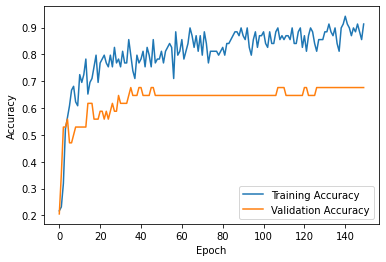

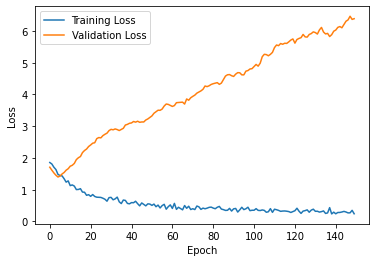

Best validation accuracy: 0.6764705777168274
Training accuracy at the best test accuracy: 0.7971014380455017
Best validation accuracy: 0.6764705777168274
Closest training accuracy to the maximum validation accuracy: 0.7971014380455017
Confusion matrix:
[[7 0 0 0 0 0]
 [2 0 0 1 0 0]
 [0 0 2 0 0 0]
 [0 3 0 8 0 0]
 [0 0 0 0 5 0]
 [0 0 0 0 5 1]]
Total Accuracy: 67.64705882352942
Total Precision: 0.6944444444444443
Total Recall: 0.648989898989899
TP for each label [7 0 2 8 5 1]
Total data for each label [ 7  3  2 11  5  6]
FP for each label [2 3 0 1 5 0]
FN for each label [0 3 0 3 0 5]
Accuracy for each label: [ 77.77777778   0.         100.          88.88888889  50.
 100.        ]
Precision for each label: [0.77777778 0.         1.         0.88888889 0.5        1.        ]
Recall for each label: [1.         0.         1.         0.72727273 1.         0.16666667]


/tmp/ipykernel_191015/2608161719.py:60: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * (precision * recall) / (precision + recall)


In [16]:
run_model(ratio_3, callback_3)

/tmp/ipykernel_191015/820102873.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(label_train)
/tmp/ipykernel_191015/820102873.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(label_test)
/tmp/ipykernel_191015/820102873.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(label_train)
/tmp/ipykernel_191015/820102873.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(label_test)
/tmp/ipykernel_191015/820102873.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futur

   Peruntukan  Jarak_pusat_kota2 Visibilitas Bangunan   Luas
4       Sawah        5078.908690      Kurang   Kosong  45000
6       Sawah        1879.054170      Kurang   Kosong  18340
7       Sawah        1998.062583      Kurang   Kosong  18110
8       Sawah        2040.538807      Kurang   Kosong  17770
14      Sawah        1629.234516      Kurang   Kosong  13155
..        ...                ...         ...      ...    ...
29      Pasar        1730.459693   Strategis    Bagus   5784
32      Pasar        2406.214384   Strategis    Bagus   5200
57      Pasar        1031.829535   Strategis    Bagus   2252
64      Pasar        1703.886238   Strategis    Bagus   1735
69      Pasar        3310.271455   Strategis    Bagus   1490

[81 rows x 5 columns]
    Peruntukan  Jarak_pusat_kota2 Visibilitas Bangunan  Luas
50       Sawah        2614.434517      Kurang   Kosong  3176
52       Sawah        3679.067767      Kurang   Kosong  2786
54       Sawah        2383.267898      Kurang   Kosong  2630
5

41/41 [==============================] - 0s 3ms/step - loss: 0.6619 - accuracy: 0.7407 - val_loss: 3.6824 - val_accuracy: 0.6364
Epoch 44/150
41/41 [==============================] - 0s 3ms/step - loss: 0.5878 - accuracy: 0.8025 - val_loss: 3.5637 - val_accuracy: 0.5909
Epoch 45/150
41/41 [==============================] - 0s 3ms/step - loss: 0.5764 - accuracy: 0.7654 - val_loss: 3.5226 - val_accuracy: 0.6364
Epoch 46/150
41/41 [==============================] - 0s 3ms/step - loss: 0.6638 - accuracy: 0.6914 - val_loss: 3.7198 - val_accuracy: 0.6364
Epoch 47/150
41/41 [==============================] - 0s 3ms/step - loss: 0.5596 - accuracy: 0.8148 - val_loss: 3.7925 - val_accuracy: 0.6364
Epoch 48/150
41/41 [==============================] - 0s 3ms/step - loss: 0.5635 - accuracy: 0.7654 - val_loss: 3.7521 - val_accuracy: 0.5909
Epoch 49/150
41/41 [==============================] - 0s 3ms/step - loss: 0.5550 - accuracy: 0.7654 - val_loss: 3.8376 - val_accuracy: 0.5909
Epoch 50/150
41/41 

Epoch 101/150
41/41 [==============================] - 0s 3ms/step - loss: 0.3515 - accuracy: 0.8395 - val_loss: 4.3136 - val_accuracy: 0.6818
Epoch 102/150
41/41 [==============================] - 0s 3ms/step - loss: 0.2982 - accuracy: 0.9136 - val_loss: 4.2716 - val_accuracy: 0.6818
Epoch 103/150
41/41 [==============================] - 0s 3ms/step - loss: 0.3149 - accuracy: 0.8889 - val_loss: 4.2647 - val_accuracy: 0.6364
Epoch 104/150
41/41 [==============================] - 0s 3ms/step - loss: 0.3910 - accuracy: 0.8272 - val_loss: 4.2600 - val_accuracy: 0.6364
Epoch 105/150
41/41 [==============================] - 0s 3ms/step - loss: 0.3215 - accuracy: 0.8642 - val_loss: 4.3430 - val_accuracy: 0.6364
Epoch 106/150
41/41 [==============================] - 0s 3ms/step - loss: 0.2957 - accuracy: 0.9012 - val_loss: 4.3636 - val_accuracy: 0.6364
Epoch 107/150
41/41 [==============================] - 0s 3ms/step - loss: 0.3734 - accuracy: 0.8272 - val_loss: 4.3706 - val_accuracy: 0.6818

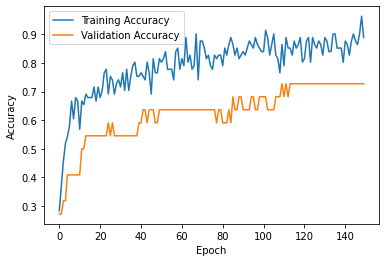

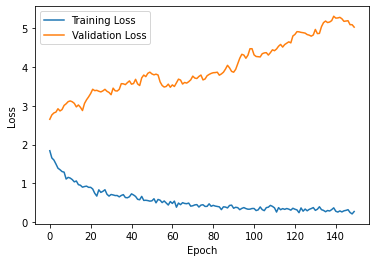

Best validation accuracy: 0.7272727489471436
Training accuracy at the best test accuracy: 0.8641975522041321
Best validation accuracy: 0.7272727489471436
Closest training accuracy to the maximum validation accuracy: 0.8641975522041321
Confusion matrix:
[[5 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 4 0 3]
 [0 0 0 0 3 0]
 [0 0 0 0 3 1]]
Total Accuracy: 72.72727272727273
Total Precision: 0.7916666666666666
Total Recall: 0.8035714285714285
TP for each label [5 2 1 4 3 1]
Total data for each label [5 2 1 7 3 4]
FP for each label [0 0 0 0 3 3]
FN for each label [0 0 0 3 0 3]
Accuracy for each label: [100. 100. 100. 100.  50.  25.]
Precision for each label: [1.   1.   1.   1.   0.5  0.25]
Recall for each label: [1.         1.         1.         0.57142857 1.         0.25      ]


In [17]:
run_model(ratio_4, callback_4)

In [18]:
run_model(ratio_5, callback_5)

/tmp/ipykernel_191015/820102873.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(label_train)
/tmp/ipykernel_191015/820102873.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(label_test)
/tmp/ipykernel_191015/820102873.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(label_train)
/tmp/ipykernel_191015/820102873.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(label_test)
/tmp/ipykernel_191015/820102873.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futur

   Peruntukan  Jarak_pusat_kota2 Visibilitas Bangunan   Luas
4       Sawah        5078.908690      Kurang   Kosong  45000
6       Sawah        1879.054170      Kurang   Kosong  18340
7       Sawah        1998.062583      Kurang   Kosong  18110
8       Sawah        2040.538807      Kurang   Kosong  17770
14      Sawah        1629.234516      Kurang   Kosong  13155
..        ...                ...         ...      ...    ...
57      Pasar        1031.829535   Strategis    Bagus   2252
64      Pasar        1703.886238   Strategis    Bagus   1735
69      Pasar        3310.271455   Strategis    Bagus   1490
70      Pasar        1530.595895   Strategis    Bagus   1380
71      Pasar         633.031834   Strategis    Bagus   1320

[90 rows x 5 columns]
    Peruntukan  Jarak_pusat_kota2 Visibilitas Bangunan  Luas
54       Sawah        2383.267898      Kurang   Kosong  2630
56       Sawah        2119.585885      Kurang   Kosong  2370
61       Sawah       17194.256034      Kurang   Kosong  2000
3

BlockingIOError: [Errno 11] Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

# 

# Print the method

In [ ]:
training, test_2 = get_data_with_ratio(0.5)
training.head()

In [ ]:
test_2.head()

In [ ]:
#split data

    
    #change data to number
training = change_categorical_to_number(training)
test = change_categorical_to_number(test_2)

training.head()

In [ ]:
test_2.head()

In [ ]:

train_ds = df_to_dataset(training)
val_ds = df_to_dataset(test)
    
    #encoded features
dataset = train_ds  # Your dataset here

# Create an iterator for the dataset
iterator = dataset.make_one_shot_iterator()

# Get the next element from the iterator
next_element = iterator.get_next()

# Create a TensorFlow session
with tf.Session() as sess:
    try:
        while True:
            # Fetch and print the next element from the dataset
            element = sess.run(next_element)
            print(element)
    except tf.errors.OutOfRangeError:
        # This exception will be raised when all elements have been iterated through
        pass

In [ ]:
dataset = train_ds  # Your dataset here

# Create an iterator for the dataset
iterator = dataset.make_one_shot_iterator()

# Get the next element from the iterator
next_element = iterator.get_next()

# Create a TensorFlow session
with tf.Session() as sess:
    try:
        while True:
            # Fetch and print the next element from the dataset
            element = sess.run(next_element)
            print(element)
    except tf.errors.OutOfRangeError:
        # This exception will be raised when all elements have been iterated through
        pass

In [ ]:
encoded,inputs = encoded_features(train_ds)

    
